In [1]:
import os
import pathlib
import nltk
import numpy as np
from unicodedata import normalize
import collections
%reload_ext autoreload
%autoreload 2

from simplifier import *

nltk.download('words')


[nltk_data] Downloading package words to /home/filipp/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
path_data = 'data-simplification/wikilarge/wiki.full.aner.'

In [3]:
train_src = open(path_data+'train.src', "r").readlines()
train_dst = open(path_data+'train.dst', "r").readlines()
train_ori_src = open(path_data+'ori.train.src', "r").readlines()
train_ori_dst = open(path_data+'ori.train.dst', "r").readlines()

valid_src = open(path_data+'valid.src', "r").readlines()
valid_dst = open(path_data+'valid.dst', "r").readlines()
valid_ori_src = open(path_data+'ori.valid.src', "r").readlines()
valid_ori_dst = open(path_data+'ori.valid.dst', "r").readlines()

### Comparison of datasets; will work with original first. Named entity identification is applied to get the modified dataset. Might facilitate trainining working with this.

In [4]:
train_src[114]

'ORGANIZATION@1 crews conducted backburning operations to ensure containment of the fire on NUMBER@1 February , warning residents of areas between LOCATION@1 and Warragul about smoke from those fires .\n'

In [5]:
train_ori_src[114]

'DSE crews conducted backburning operations to ensure containment of the fire on 9 February , warning residents of areas between Pakenham and Warragul about smoke from those fires .\n'

In [6]:
train_ori_dst[114]

'People between Pakenham and Warragul were warned about smoke from those fires .\n'

In [7]:
train_dst[114]

'People between LOCATION@1 and Warragul were warned about smoke from those fires .\n'

In [8]:
valid_ori_dst[11]

'Thousands of young people from all over the world went to San Francisco to help create a hippie counterculture . The Summer of Love made the rest of America much more aware of the hippie movement .\n'

In [9]:
embedding_index = {}
file = os.path.join(str(pathlib.Path.home())+"/GloVe","glove.6B.100d.txt")
f= open(file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs



### A glimpse at the representations.

In [10]:
i = 0
for key, value in embedding_index.items():
    if i>5:
        break
    print(key, value)
    print(value.shape)
    i += 1

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

In [11]:
clean_txt = clean(train_ori_src)

In [12]:
train_ori_src[0:2]

["There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .\n",
 "In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .\n"]

In [13]:
clean_txt[0:400]

'there is manuscript evidence that austen continued to work on these pieces as late as the period a and that her niece and nephew anna and james edward austen made further additions as late asin a remarkable comparative analysis mandaean scholar demonstrated that mani psalms of thomas were closely related to mandaean textsbefore persephone was released to hermes who had been sent to retrieve her ha'

In [14]:
token_list_src = nltk.word_tokenize(clean_txt)
print(token_list_src[0:20],"\n")
print("Total tokens : ", len(token_list_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that'] 

Total tokens :  5742368


In [15]:
# comparison with source tokens when entities replaced by placeholders
token_list_with_ent_src = nltk.word_tokenize(clean(train_src))
print(token_list_with_ent_src[0:20],"\n")
print("Total tokens : ", len(token_list_with_ent_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that', 'her'] 

Total tokens :  4961048


In [16]:
#total vocabulary size in source
len(set(token_list_src))

332341

### Looking at the frequencies

In [17]:

token_list_src_over_threshold = build_vocabulary(tokenize(clean(train_ori_src)), threshold=10)
vocabulary_size_source = len(token_list_src_over_threshold) + 1
print(vocabulary_size_source)
token_list_src_over_threshold[:10]

27266


[('the', 414529),
 ('of', 238408),
 ('and', 180703),
 ('in', 180597),
 ('a', 158684),
 ('is', 116580),
 ('to', 102777),
 ('was', 61810),
 ('as', 55788),
 ('by', 45144)]

### Which words/tokens from corpus are missing in GloVe; obviously lots of misspelled/not properly separated words.

In [18]:
not_in_GloVe = []
for word, _ in token_list_src_over_threshold:
    if word not in embedding_index:
        not_in_GloVe.append(word)
len(not_in_GloVe)

1871

### Using spell checker a la Norvig

In [19]:
from spellchecker import *

In [20]:
separate_words("umbrellaas", embedding_index)

['umbrella', 'as']

#### Separating a word not in the embedding might give two words in the embedding. Run a couple of times, to see that the number of words not in GloVe decreases

In [21]:
for word in not_in_GloVe:
    if len(separate_words(word, embedding_index))>1:
        not_in_GloVe.remove(word)
        
len(not_in_GloVe)

954

In [22]:
not_in_GloVe[:20]

['francein',
 'franceit',
 'francehe',
 'germanythe',
 'switzerlandthe',
 'timethe',
 'englandthe',
 'citythe',
 'thethe',
 'franceis',
 'francethis',
 'centurythe',
 'leaguethe',
 'areathe',
 'calendarthe',
 'francethey',
 'maythe',
 'francendash',
 'octoberthe',
 'julythe']

In [23]:
improved_token_list = improve_token_list([x[0] for x in token_list_src_over_threshold], \
                                         embedding_index, separate_words)

In [24]:
improved_token_list = list((set(improved_token_list)))
len(improved_token_list)

26253

### Creating token-index-dictionary

In [25]:
tokenizer_src = build_word2index(improved_token_list)

In [26]:
len(tokenizer_src)

26254

### embedding matrix to use the GloVe embedding in the model later

In [27]:
embedding_size = 100 # GloVe 100d
vocabulary_size_source = len(tokenizer_src)+1
embedding_matrix = np.zeros((vocabulary_size_source, embedding_size))
for word, idx in tokenizer_src.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [28]:
test = train_ori_src[120]
test

'Sirius left Portsmouth on 13 May 1787 , and arrived at Port Jackson on 26 January 1788 .\n'

In [29]:
len(tokenizer(test))

16

### Let's look at sentence lengths

In [30]:
lengths=[]
lengths = [len((tokenizer(x))) for x in train_ori_src]

In [31]:
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("max", np.max(lengths))
print("std", np.std(lengths))

min 0
mean 22.678625650299256
max 104
std 11.685398987054729


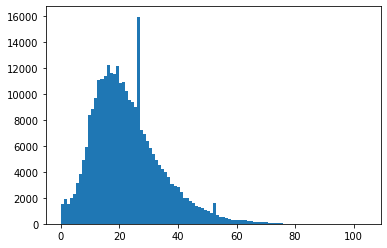

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()
plt.close()

In [33]:
np.argmax(lengths)

26105

In [34]:
np.argmin(lengths)

607

In [35]:
train_ori_src[26105]

'DreamWorks Animation has produced some of the highest grossing animated hits of all time , such as Antz -LRB-/O1998/O-RRB- , The Prince of Egypt -LRB-/O1998/O-RRB- , Shrek -LRB-/O2001/O-RRB- , its sequels Shrek 2 -LRB-/O2004/O-RRB- , Shrek the Third -LRB-/O2007/O-RRB- and Shrek Forever After -LRB-/O2010/O-RRB- ; Shark Tale -LRB-/O2004/O-RRB- , Madagascar -LRB-/O2005/O-RRB- , Over the Hedge -LRB-/O2006/O-RRB- , Flushed Away -LRB-/O2006/O-RRB- , Bee Movie -LRB-/O2007/O-RRB- , Kung Fu Panda -LRB-/O2008/O-RRB- and How to Train Your Dragon -LRB-/O2010/O-RRB- .\n'

In [36]:
train_ori_src[607]

"! ''\n"

In [37]:
sentence_length = 50

In [38]:
train_x = np.array([encoder(tokenizer(line), \
                            tokenizer_src, sentence_length) for line in \
                    train_ori_src]).reshape(-1, sentence_length)

In [39]:
train_x.shape

(296402, 50)

In [40]:
get_word(3760, tokenizer_src)

'ora'

In [41]:
print(train_ori_src[12:13])
print([tokenizer(line) for line in train_ori_src[12:13]])
print(train_x[12:13])

['Plays and comic puppet theater loosely based on this legend were popular throughout Germany in the 16th century , often reducing Faust and Mephistopheles to figures of vulgar fun .\n']
[['plays', 'and', 'comic', 'puppet', 'theater', 'loosely', 'based', 'on', 'this', 'legend', 'were', 'popular', 'throughout', 'germany', 'in', 'the', '16th', 'century', 'often', 'reducing', 'faust', 'and', 'mephistopheles', 'to', 'figures', 'of', 'vulgar', 'fun']]
[[20621  8289  6051 13698  3244  3348 17759 12418 11609   837 12199 11318
   4760 24521 18273 14198 26254   763 16891  9142  1824  8289 26254 14391
  18683 11142 15491 16571     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [42]:
lengths_dst = [len((tokenizer(x))) for x in train_ori_dst]

In [43]:
print("min", np.min(lengths_dst))
print("mean", np.mean(lengths_dst))
print("max", np.max(lengths_dst))
print("std", np.std(lengths_dst))

min 0
mean 16.679013636885042
max 80
std 10.492046320896975


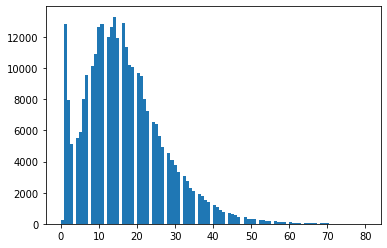

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths_dst, bins=100)
plt.show()
plt.close()

In [45]:
sentence_length_dst = 40

### Look at output vocabulary

In [46]:
token_list_dst_over_threshold = build_vocabulary(tokenize(clean(train_ori_dst)), threshold=10)
vocabulary_size_dst = len(token_list_dst_over_threshold) + 1
print(vocabulary_size_dst)
token_list_dst_over_threshold[:10]

20570


[('the', 300506),
 ('of', 169568),
 ('in', 134603),
 ('a', 119036),
 ('and', 114305),
 ('is', 109630),
 ('to', 69806),
 ('was', 54588),
 ('for', 31547),
 ('by', 29698)]

In [47]:
improved_token_list_dst = improve_token_list([x[0] for x in token_list_dst_over_threshold], \
                                         embedding_index, separate_words)
improved_token_list_dst = list((set(improved_token_list_dst)))
vocabulary_size_dst = len(improved_token_list_dst) + 1
print(vocabulary_size_dst)

19665


In [48]:
tokenizer_dst = build_word2index(improved_token_list_dst)
len(tokenizer_dst)

19665

In [49]:
train_y = np.array([encoder(tokenizer(line), \
                            tokenizer_dst, sentence_length_dst) for line in \
                    train_ori_dst]).reshape(-1, sentence_length_dst)

In [50]:
train_y.shape

(296402, 40)

In [51]:
import gc
gc.collect()

9279

In [52]:
0 in tokenizer_src.values()

False

In [53]:
from tensorflow.keras.callbacks import Callback
class NeptuneMonitor(Callback):
    def on_epoch_end(self, epoch, logs={}):
        my_metric = logs['loss']
        neptune.send_metric('Sparse Categorical Cross Entropy', epoch, my_metric)

In [54]:
from model import *

In [55]:
embedding_matrix.shape[-1]

100

In [123]:
mod = build_model(vocabulary_size_source, vocabulary_size_dst, sentence_length, \
                  sentence_length_dst, 100, embedding_matrix, unfreeze_emb=True)

In [62]:
mod = build_model(vocabulary_size_source, vocabulary_size_dst, sentence_length, \
                  sentence_length_dst, 32)

In [63]:
mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 32)            840192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 32)            8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 19666)         648978    
Total params: 1,505,810
Trainable params: 1,505,810
Non-trainable params: 0
_________________________________________________

In [58]:
train_y.shape

(296402, 40)

In [ ]:

# import datetime
# import neptune
# #from simplifier import generator
# #import tensorboard

# #PARAMS = {'n_iterations': 117,
# #          'n_images': 5}

# # neptune.init('l-theorist/sandbox',
# #              api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDYyODYzNzAtNWMzOC00ZTY5LWJkMjYtYTRhNTVkNWM4MWZjIn0=')





# rms = optimizers.RMSprop(lr=0.001)
# nadm =optimizers.Nadam(learning_rate=0.008, beta_1=0.99, beta_2=0.99999)
# admx = optimizers.Adamax(learning_rate=0.0006, beta_1=0.999, beta_2=0.999999)
# mod.compile(
#     optimizer=rms,
#     #optimizer="adam",
#     #loss="categorical_crossentropy",
#     loss="sparse_categorical_crossentropy",
#     #metrics=["accuracy"]

# )


# with neptune.create_experiment(name='baseline simplifier',
#                                #params=PARAMS
#                               ):
#     neptune_monitor = NeptuneMonitor()
   

batch_size = 64
n_samples = 64 #train_x.shape[0]
history = mod.fit_generator(
    generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False),
    #data_gen,
    #(train_gen(train_x, 500), one_hot_encode_output(train_y_gen)),
    epochs=100,
    #batch_size=50,
    #validation_split=0.2,
    #steps_per_epoch = train_x.shape[0]/batch_size,
    steps_per_epoch = n_samples/batch_size,
  #  callbacks=[neptune_monitor]
    

)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.6552
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 2.6573
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 2.6837
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 2.6531
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 2.6395
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 2.6472
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 2.6796
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 2.6358
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 2.6225
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 2.6202
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 2.6420
Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 2.6387
Epoch 13/100
1/1 [==============================] - 1s 1s/step - loss: 2.

In [162]:
mod.predict_classes(train_x[10:12])

AttributeError: 'Model' object has no attribute 'predict_classes'

In [133]:
mod.layers

In [144]:
from tensorflow import keras
from kerastuner import HyperModel


class SimpleHyperModel(HyperModel):
    def __init__(self, vocab_in, vocab_out, length_in, length_out, n_units, \
                    use_emb=None, unfreeze_emb=True):
        self.vocab_in = vocab_in
        self.vocab_out = vocab_out
        self.length_in = length_in
        self.length_out = length_out
        self.n_units = n_units
        self.use_emb = use_emb
        self.unfreeze_emb = unfreeze_emb
        

    def build(self, hp):
        
        if self.use_emb is not None:
            assert self.n_units==self.use_emb.shape[-1], "Embedding dimension should match n_units."
        encoder_input = Input(shape=(self.length_in,))
        encoder_output = layers.Embedding(self.vocab_in+1,
                                        self.n_units,
                                        input_length=self.length_in,
                                        embeddings_initializer='lecun_uniform',
                                        mask_zero=True,
                                        trainable=True)(encoder_input)
        encoder_output = layers.LSTM(self.n_units)(encoder_output)
        encoder_output = layers.RepeatVector(self.length_out)(encoder_output)
        decoder_output = layers.LSTM(self.n_units, return_sequences=True)(encoder_output)
        decoder_output = layers.TimeDistributed(layers.Dense(self.vocab_out+1, activation='softmax'))(decoder_output)

        model = models.Model(encoder_input, decoder_output)
        if self.use_emb is not None:
            model.layers[1].set_weights([self.use_emb])
            model.layers[1].trainable = self.unfreeze_emb




        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            #metrics=['accuracy']
        )
        return model

hypermodel = SimpleHyperModel(vocabulary_size_source, vocabulary_size_dst, sentence_length, \
                  sentence_length_dst, 512)

In [157]:
from kerastuner.tuners import RandomSearch #,Hyperband
HYPERBAND_MAX_EPOCHS=20
SEED=17
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 2



tuner = RandomSearch(
    hypermodel,
    #max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='loss',
    max_trials=MAX_TRIALS,
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='randomsearch',
    project_name='fil'
)

In [158]:
tuner.search_space_summary()

In [159]:
N_EPOCH_SEARCH = 20
batch_size = 128
n_samples = 256 #train_x.shape[0]
tuner.search_generator(generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False), epochs=N_EPOCH_SEARCH)

AttributeError: 'RandomSearch' object has no attribute 'search_generator'

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.history.history["loss"], label="loss")
#plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()
plt.close()

In [ ]:
model.summary()

In [ ]:
model.predict(train_x[10:11]).shape

In [ ]:
train_ori_src[10:11]

In [ ]:
train_x[10:11]

In [ ]:
model.predict_classes(train_x[10:11])

In [84]:
convert(model.predict_classes(train_x[10:11]), token_dict=tokenizer_dst)

['                                                 ']

In [85]:
convert(train_x[10:11], tokenizer_src)

['many still refer to <UNK>  and <UNK>  as <UNK>  and <UNK>  respectively not unlike the usage of bit in american english for a                       ']

In [ ]:
train_ori_dst[10:11]

In [89]:
from tensorflow.keras.models import load_model
model = load_model("model_all_1.h5")

In [ ]:
np.sum(model.get_weights()[0])

In [ ]:
from tensorflow.keras.models import load_model
mdl = load_model("first_3K_smod.h5")

In [ ]:
np.sum(mdl.get_weights()[0])

In [ ]:
train_x[indx]

In [ ]:
train_y[indx]

In [ ]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)
    integers = [np.argmax(vector) for vector in prediction]
    return convert(integers, tokenizer)

In [ ]:
predict_sequence(model, tokenizer_dst, train_x[10:11])

In [ ]:
prediction = model.predict(train_x[indx], verbose=0)[0]

In [ ]:
integers = [np.argmax(vector) for vector in prediction]

In [ ]:
prediction[1]